# Linear Regression Part 1: Fundamentals

## Learning Objectives
By the end of this session, you will be able to:
- Understand linear regression theory and assumptions
- Implement simple and multiple linear regression in Python
- Interpret regression coefficients in business context
- Validate regression assumptions and diagnose problems
- Build predictive models for e-commerce business metrics

## Environment Setup

We'll set up our environment with regression-specific libraries and database connectivity.

In [1]:
# Standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and machine learning libraries
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_harvey_collier, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Database connectivity
from sqlalchemy import create_engine
import psycopg2
import os
from dotenv import load_dotenv

# Visualization styling
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 8)

# Load environment variables
load_dotenv()

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Environment setup complete for regression analysis!")

Environment setup complete for regression analysis!


## Database Connection Setup

Establishing connection to our Supabase PostgreSQL database with the Olist dataset.

In [2]:
# Load environment variables from .env file
load_dotenv()

# Database configuration - reading from environment variables
DATABASE_CONFIG = {
    'host': os.getenv('POSTGRES_HOST'),
    'port': os.getenv('POSTGRES_PORT', '6543'),
    'database': os.getenv('POSTGRES_DATABASE', 'postgres'),
    'user': os.getenv('POSTGRES_USER'),
    'password': os.getenv('POSTGRES_PASSWORD')
}

def create_database_connection():
    """
    Create a SQLAlchemy engine for database connections.
    
    Returns:
        sqlalchemy.engine.Engine: Database engine for executing queries
    """
    # Check if all required credentials are available
    required_fields = ['host', 'user', 'password']
    missing_fields = [field for field in required_fields if not DATABASE_CONFIG[field]]
    
    if missing_fields:
        raise ValueError(f"Missing database credentials: {missing_fields}")
    
    connection_string = f"postgresql://{DATABASE_CONFIG['user']}:{DATABASE_CONFIG['password']}@{DATABASE_CONFIG['host']}:{DATABASE_CONFIG['port']}/{DATABASE_CONFIG['database']}"
    engine = create_engine(connection_string, pool_size=5, max_overflow=10)
    return engine

# Test database connection
try:
    engine = create_database_connection()
    
    # Use proper SQLAlchemy syntax for newer versions
    from sqlalchemy import text
    test_query = text("SELECT 1 as test")
    
    with engine.connect() as conn:
        test_result = conn.execute(test_query)
        result_value = test_result.scalar()
        print("✅ Database connection successful!")
        print(f"Test result: {result_value}")
        
except Exception as e:
    print(f"❌ Database connection failed: {str(e)}")
    print("Please check your .env file and database credentials.")
    
    # Debug information
    print("\nDebug information:")
    print(f"Host: {DATABASE_CONFIG['host']}")
    print(f"Port: {DATABASE_CONFIG['port']}")
    print(f"Database: {DATABASE_CONFIG['database']}")
    print(f"User: {DATABASE_CONFIG['user']}")
    print(f"Password: {'*' * len(DATABASE_CONFIG['password']) if DATABASE_CONFIG['password'] else 'None'}")

print("🔒 Security Note: Database credentials loaded from .env file")

✅ Database connection successful!
Test result: 1
🔒 Security Note: Database credentials loaded from .env file


# Linear Regression Theory and Fundamentals

## What is Linear Regression?

Linear regression is a statistical method that models the relationship between a dependent variable (target) and one or more independent variables (features) using a linear equation.

### Simple Linear Regression
**Formula**: y = β₀ + β₁x + ε

Where:
- y = dependent variable (what we're predicting)
- x = independent variable (predictor)
- β₀ = intercept (y-value when x = 0)
- β₁ = slope (change in y for unit change in x)
- ε = error term

### Multiple Linear Regression
**Formula**: y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε

## Key Assumptions
1. **Linearity**: Relationship between variables is linear
2. **Independence**: Observations are independent
3. **Homoscedasticity**: Constant variance of residuals
4. **Normality**: Residuals are normally distributed
5. **No multicollinearity**: Independent variables aren't highly correlated

# Data Preparation for Regression Analysis

## Loading E-commerce Data for Regression

We'll create a comprehensive dataset for predicting customer order values based on various business factors.

In [4]:
def load_regression_dataset():
    """
    Load and prepare data for regression analysis.
    Target: Predict order value based on customer and order characteristics.
    
    Returns:
        pd.DataFrame: Prepared regression dataset
    """
    query = """
    WITH order_features AS (
        SELECT 
            o.order_id,
            o.customer_id,
            c.customer_state,
            
            -- Target variable: total order value
            SUM(oi.price + oi.freight_value) as order_value,
            
            -- Features: order characteristics
            COUNT(oi.order_item_id) as item_count,
            AVG(oi.price) as avg_item_price,
            SUM(oi.freight_value) as total_freight,
            
            -- Features: product characteristics
            COUNT(DISTINCT t.product_category_name_english) as category_count,
            AVG(p.product_weight_g) as avg_product_weight,
            AVG(p.product_length_cm * p.product_height_cm * p.product_width_cm) as avg_product_volume,
            
            -- Features: temporal
            EXTRACT(MONTH FROM o.order_purchase_timestamp) as purchase_month,
            EXTRACT(DOW FROM o.order_purchase_timestamp) as purchase_day_of_week,
            EXTRACT(HOUR FROM o.order_purchase_timestamp) as purchase_hour,
            
            -- Features: delivery
            EXTRACT(DAYS FROM (o.order_delivered_customer_date - o.order_purchase_timestamp)) as delivery_days,
            
            -- Features: customer satisfaction
            r.review_score
            
        FROM "olist_sales_data_set"."olist_orders_dataset" o
        INNER JOIN "olist_sales_data_set"."olist_customers_dataset" c 
            ON o.customer_id = c.customer_id
        INNER JOIN "olist_sales_data_set"."olist_order_items_dataset" oi 
            ON o.order_id = oi.order_id
        INNER JOIN "olist_sales_data_set"."olist_products_dataset" p 
            ON oi.product_id = p.product_id
        LEFT JOIN "olist_sales_data_set"."product_category_name_translation" t 
            ON p.product_category_name = t.product_category_name
        LEFT JOIN "olist_sales_data_set"."olist_order_reviews_dataset" r 
            ON o.order_id = r.order_id
        WHERE o.order_status = 'delivered'
            AND o.order_delivered_customer_date IS NOT NULL
            AND p.product_weight_g IS NOT NULL
            AND p.product_length_cm IS NOT NULL
            AND p.product_height_cm IS NOT NULL
            AND p.product_width_cm IS NOT NULL
        GROUP BY 
            o.order_id, o.customer_id, c.customer_state,
            o.order_purchase_timestamp, o.order_delivered_customer_date,
            r.review_score
        HAVING SUM(oi.price + oi.freight_value) > 0
            AND COUNT(oi.order_item_id) <= 20  -- Remove extreme outliers
    ),
    regional_mapping AS (
        SELECT 
            *,
            CASE 
                WHEN customer_state IN ('SP', 'RJ', 'ES', 'MG') THEN 'Southeast'
                WHEN customer_state IN ('PR', 'SC', 'RS') THEN 'South'
                WHEN customer_state IN ('GO', 'MT', 'MS', 'DF') THEN 'Center-West'
                WHEN customer_state IN ('BA', 'SE', 'PE', 'AL', 'PB', 'RN', 'CE', 'PI', 'MA') THEN 'Northeast'
                WHEN customer_state IN ('AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC') THEN 'North'
                ELSE 'Other'
            END as region
        FROM order_features
    )
    SELECT *
    FROM regional_mapping
    WHERE region != 'Other'
        AND delivery_days BETWEEN 0 AND 100  -- Remove unrealistic delivery times
        AND order_value < 2000  -- Remove extreme outliers for stable regression
    ORDER BY RANDOM()
    LIMIT 5000  -- Sample for demonstration
    """
    
    return pd.read_sql(query, engine)

# Load regression dataset
regression_df = load_regression_dataset()

print(f"Loaded {len(regression_df):,} orders for regression analysis")
print(f"\nDataset shape: {regression_df.shape}")
print(f"\nTarget variable (order_value) statistics:")
print(regression_df['order_value'].describe())

# Check for missing values
missing_values = regression_df.isnull().sum()
print(f"\nMissing values:")
print(missing_values[missing_values > 0])

Loaded 5,000 orders for regression analysis

Dataset shape: (5000, 16)

Target variable (order_value) statistics:
count    5000.000000
mean      155.654570
std       178.819446
min        13.390000
25%        61.182500
50%       105.260000
75%       177.085000
max      1937.640000
Name: order_value, dtype: float64

Missing values:
review_score    46
dtype: int64


## Exploratory Data Analysis for Regression

Before building regression models, we need to understand our data and relationships between variables.

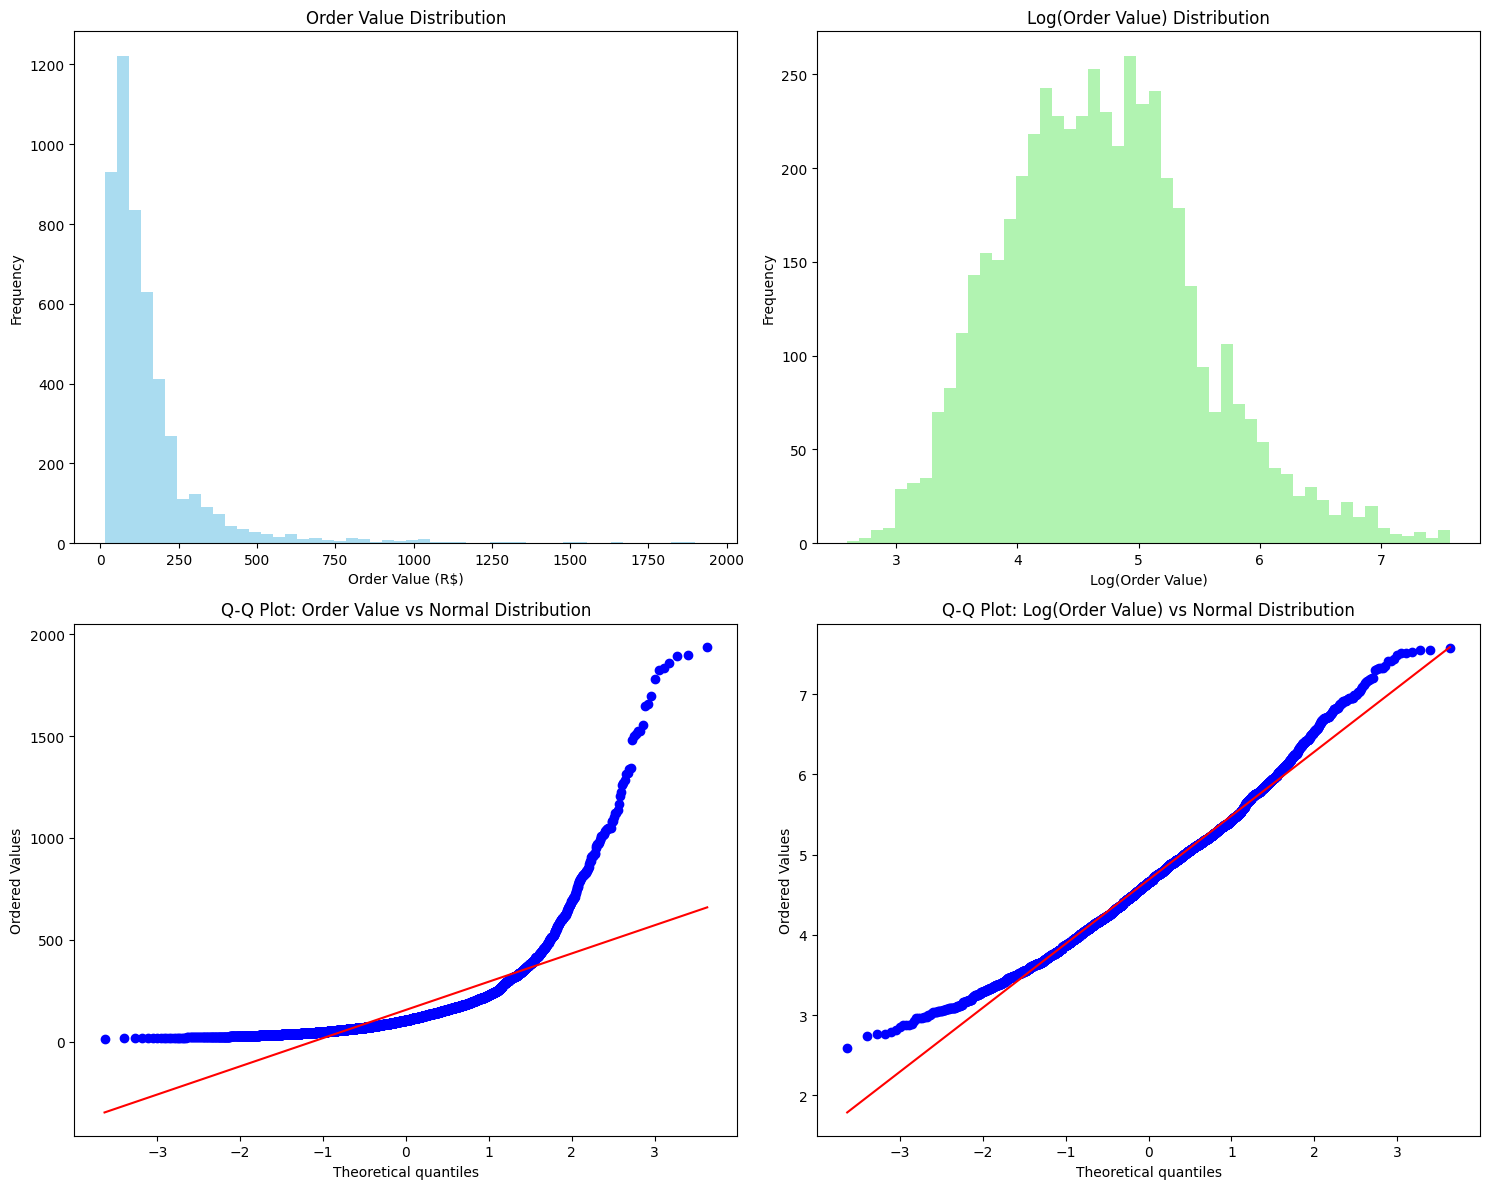


Correlation Analysis:


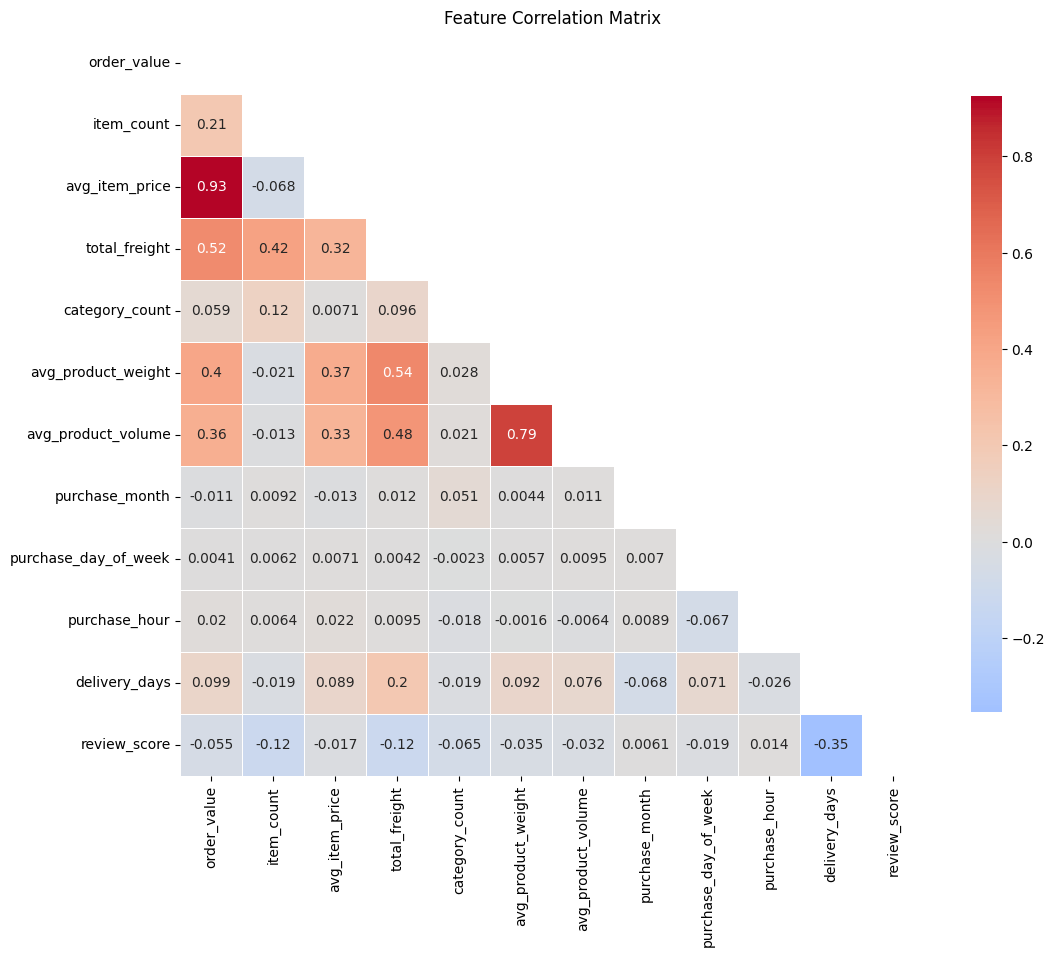


Strongest correlations with order value:
  avg_item_price: 0.926
  total_freight: 0.522
  avg_product_weight: 0.402
  avg_product_volume: 0.356
  item_count: 0.205
  delivery_days: 0.099
  category_count: 0.059
  review_score: 0.055
  purchase_hour: 0.020

KEY FEATURE RELATIONSHIPS:


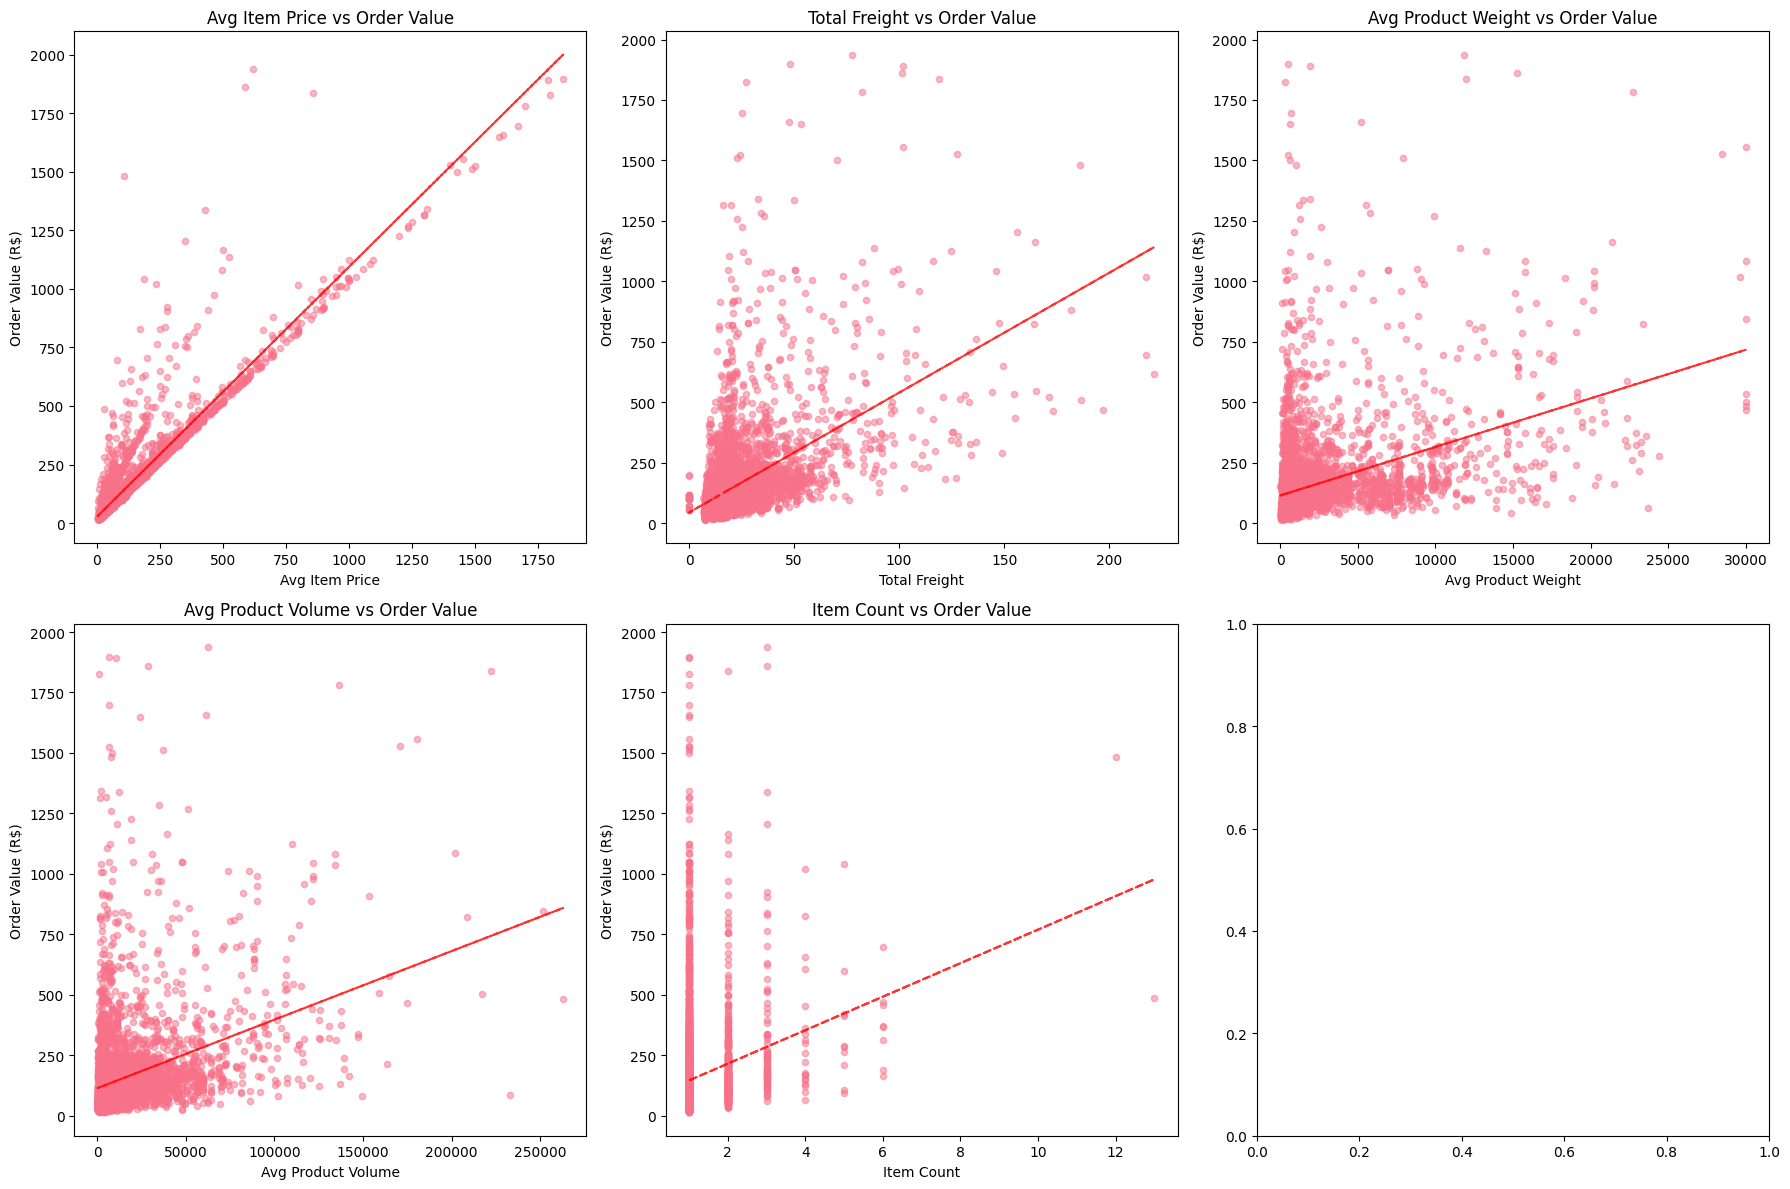

In [5]:
def perform_regression_eda(data):
    """
    Perform exploratory data analysis for regression modeling.
    
    Args:
        data (pd.DataFrame): Regression dataset
    """
    # 1. Target variable distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Original distribution
    axes[0, 0].hist(data['order_value'], bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Order Value Distribution')
    axes[0, 0].set_xlabel('Order Value (R$)')
    axes[0, 0].set_ylabel('Frequency')
    
    # Log transformation
    log_order_value = np.log(data['order_value'])
    axes[0, 1].hist(log_order_value, bins=50, alpha=0.7, color='lightgreen')
    axes[0, 1].set_title('Log(Order Value) Distribution')
    axes[0, 1].set_xlabel('Log(Order Value)')
    axes[0, 1].set_ylabel('Frequency')
    
    # Q-Q plot for normality check
    stats.probplot(data['order_value'], dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot: Order Value vs Normal Distribution')
    
    # Q-Q plot for log-transformed
    stats.probplot(log_order_value, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot: Log(Order Value) vs Normal Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Correlation analysis
    print("\nCorrelation Analysis:")
    print("=" * 25)
    
    # Select numeric columns for correlation
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    correlation_matrix = data[numeric_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Matrix')
    plt.show()
    
    # Correlations with target variable
    target_correlations = correlation_matrix['order_value'].abs().sort_values(ascending=False)
    print("\nStrongest correlations with order value:")
    for feature, corr in target_correlations.head(10).items():
        if feature != 'order_value':
            print(f"  {feature}: {corr:.3f}")
    
    # 3. Feature relationships
    print("\n" + "=" * 50)
    print("KEY FEATURE RELATIONSHIPS:")
    print("=" * 50)
    
    # Top predictors for scatter plots
    top_features = target_correlations.head(6).index.tolist()
    top_features.remove('order_value')  # Remove target variable
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, feature in enumerate(top_features[:6]):
        axes[i].scatter(data[feature], data['order_value'], alpha=0.5, s=20)
        axes[i].set_xlabel(feature.replace('_', ' ').title())
        axes[i].set_ylabel('Order Value (R$)')
        axes[i].set_title(f'{feature.replace("_", " ").title()} vs Order Value')
        
        # Add trend line
        z = np.polyfit(data[feature].dropna(), data.loc[data[feature].notna(), 'order_value'], 1)
        p = np.poly1d(z)
        axes[i].plot(data[feature], p(data[feature]), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    return target_correlations

# Perform EDA
correlations = perform_regression_eda(regression_df)

# Simple Linear Regression

## Building Our First Regression Model

Let's start with a simple linear regression using the strongest predictor of order value.

Building simple linear regression with strongest predictor: avg_item_price

Simple Linear Regression: order_value ~ avg_item_price

Statsmodels Summary:
                            OLS Regression Results                            
Dep. Variable:            order_value   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 3.003e+04
Date:                Thu, 17 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:48:05   Log-Likelihood:                -28159.
No. Observations:                5000   AIC:                         5.632e+04
Df Residuals:                    4998   BIC:                         5.633e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t

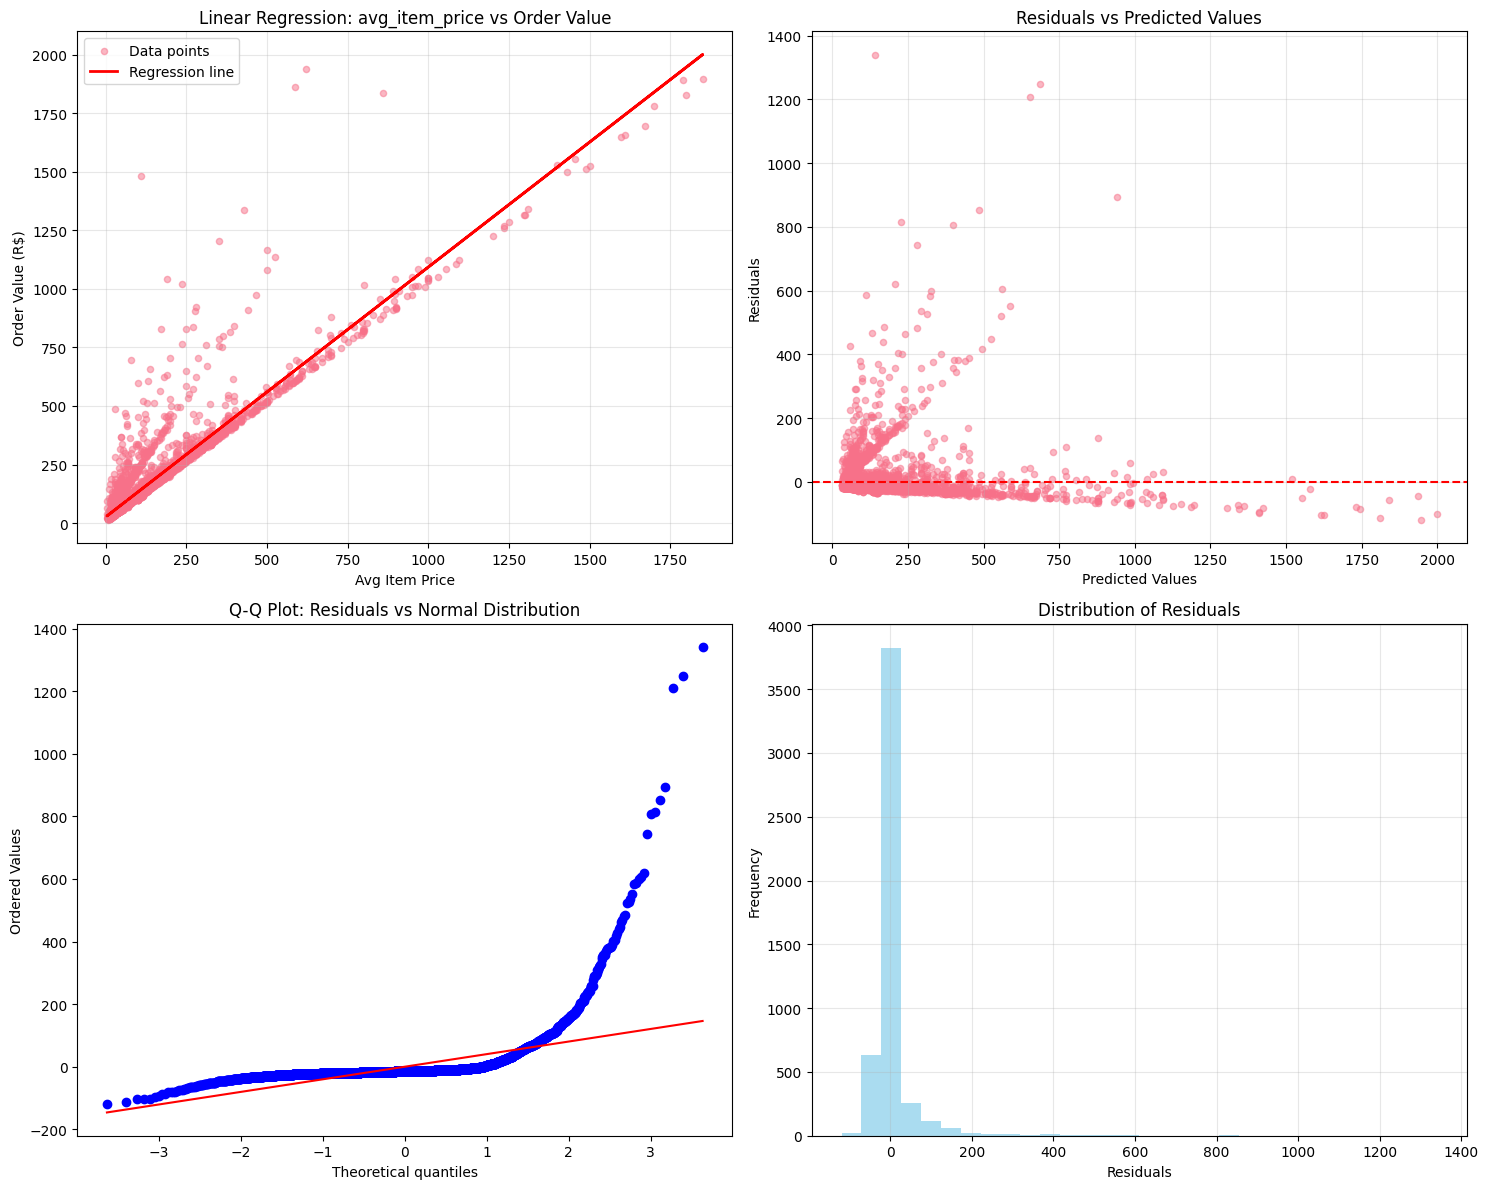

In [6]:
def build_simple_linear_regression(data, feature_col, target_col='order_value'):
    """
    Build and analyze a simple linear regression model.
    
    Args:
        data (pd.DataFrame): Dataset
        feature_col (str): Feature column name
        target_col (str): Target column name
    
    Returns:
        dict: Regression results and diagnostics
    """
    # Prepare data (remove missing values)
    clean_data = data[[feature_col, target_col]].dropna()
    X = clean_data[feature_col]
    y = clean_data[target_col]
    
    print(f"Simple Linear Regression: {target_col} ~ {feature_col}")
    print("=" * 60)
    
    # Method 1: Using statsmodels (for detailed statistics)
    X_sm = sm.add_constant(X)  # Add intercept
    model_sm = sm.OLS(y, X_sm).fit()
    
    print("\nStatsmodels Summary:")
    print(model_sm.summary())
    
    # Method 2: Using scikit-learn (for prediction focus)
    X_sklearn = X.values.reshape(-1, 1)
    model_sklearn = LinearRegression()
    model_sklearn.fit(X_sklearn, y)
    
    # Predictions
    y_pred_sm = model_sm.predict(X_sm)
    y_pred_sklearn = model_sklearn.predict(X_sklearn)
    
    # Model performance metrics
    r2_sm = model_sm.rsquared
    r2_sklearn = r2_score(y, y_pred_sklearn)
    rmse = np.sqrt(mean_squared_error(y, y_pred_sklearn))
    mae = mean_absolute_error(y, y_pred_sklearn)
    
    print(f"\n{'='*40}")
    print("MODEL PERFORMANCE METRICS:")
    print(f"{'='*40}")
    print(f"R-squared: {r2_sm:.4f}")
    print(f"Root Mean Square Error (RMSE): R$ {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): R$ {mae:.2f}")
    
    # Business interpretation
    intercept = model_sklearn.intercept_
    slope = model_sklearn.coef_[0]
    
    print(f"\n{'='*40}")
    print("BUSINESS INTERPRETATION:")
    print(f"{'='*40}")
    print(f"Intercept (β₀): R$ {intercept:.2f}")
    print(f"Slope (β₁): R$ {slope:.2f}")
    print(f"\nInterpretation:")
    print(f"• Base order value: R$ {intercept:.2f}")
    print(f"• For each unit increase in {feature_col}, order value increases by R$ {slope:.2f}")
    print(f"• The model explains {r2_sm*100:.1f}% of the variance in order value")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Scatter plot with regression line
    axes[0, 0].scatter(X, y, alpha=0.5, s=20, label='Data points')
    axes[0, 0].plot(X, y_pred_sklearn, color='red', linewidth=2, label='Regression line')
    axes[0, 0].set_xlabel(feature_col.replace('_', ' ').title())
    axes[0, 0].set_ylabel('Order Value (R$)')
    axes[0, 0].set_title(f'Linear Regression: {feature_col} vs Order Value')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Residuals plot
    residuals = y - y_pred_sklearn
    axes[0, 1].scatter(y_pred_sklearn, residuals, alpha=0.5, s=20)
    axes[0, 1].axhline(y=0, color='red', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residuals vs Predicted Values')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Q-Q plot of residuals
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot: Residuals vs Normal Distribution')
    
    # 4. Histogram of residuals
    axes[1, 1].hist(residuals, bins=30, alpha=0.7, color='skyblue')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Residuals')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model_sm': model_sm,
        'model_sklearn': model_sklearn,
        'r2': r2_sm,
        'rmse': rmse,
        'mae': mae,
        'residuals': residuals,
        'predictions': y_pred_sklearn
    }

# Build simple linear regression with strongest predictor
# Get the strongest predictor (excluding order_value itself)
strongest_predictor = correlations.drop('order_value').index[0]
print(f"Building simple linear regression with strongest predictor: {strongest_predictor}\n")

simple_regression_results = build_simple_linear_regression(regression_df, strongest_predictor)

## Regression Assumptions Testing

Let's formally test the key assumptions of linear regression.

In [7]:
def test_regression_assumptions(model_sm, residuals, features_data, alpha=0.05):
    """
    Test the key assumptions of linear regression.
    
    Args:
        model_sm (statsmodels regression): Fitted statsmodels regression
        residuals (array): Model residuals
        features_data (pd.DataFrame): Feature data
        alpha (float): Significance level
    
    Returns:
        dict: Test results for each assumption
    """
    print("REGRESSION ASSUMPTIONS TESTING")
    print("=" * 40)
    
    results = {}
    
    # 1. Linearity Test (Harvey-Collier test)
    print("\n1. LINEARITY TEST (Harvey-Collier)")
    print("-" * 35)
    try:
        hc_statistic, hc_p_value = linear_harvey_collier(model_sm)
        results['linearity'] = {
            'statistic': hc_statistic,
            'p_value': hc_p_value,
            'assumption_met': hc_p_value > alpha
        }
        
        print(f"Harvey-Collier statistic: {hc_statistic:.4f}")
        print(f"P-value: {hc_p_value:.6f}")
        
        if hc_p_value > alpha:
            print(f"✅ Linearity assumption MET (p > {alpha})")
        else:
            print(f"❌ Linearity assumption VIOLATED (p <= {alpha})")
            
    except Exception as e:
        print(f"Could not perform linearity test: {e}")
        results['linearity'] = {'error': str(e)}
    
    # 2. Homoscedasticity Test (Breusch-Pagan test)
    print("\n2. HOMOSCEDASTICITY TEST (Breusch-Pagan)")
    print("-" * 42)
    try:
        bp_statistic, bp_p_value, _, _ = het_breuschpagan(residuals, model_sm.model.exog)
        results['homoscedasticity'] = {
            'statistic': bp_statistic,
            'p_value': bp_p_value,
            'assumption_met': bp_p_value > alpha
        }
        
        print(f"Breusch-Pagan statistic: {bp_statistic:.4f}")
        print(f"P-value: {bp_p_value:.6f}")
        
        if bp_p_value > alpha:
            print(f"✅ Homoscedasticity assumption MET (p > {alpha})")
        else:
            print(f"❌ Homoscedasticity assumption VIOLATED (p <= {alpha})")
            print("  → Consider using robust standard errors or transforming variables")
            
    except Exception as e:
        print(f"Could not perform homoscedasticity test: {e}")
        results['homoscedasticity'] = {'error': str(e)}
    
    # 3. Normality of Residuals Test (Shapiro-Wilk)
    print("\n3. NORMALITY OF RESIDUALS TEST (Shapiro-Wilk)")
    print("-" * 45)
    
    # Use sample for large datasets (Shapiro-Wilk limited to n <= 5000)
    residuals_sample = residuals[:min(5000, len(residuals))]
    
    sw_statistic, sw_p_value = stats.shapiro(residuals_sample)
    results['normality'] = {
        'statistic': sw_statistic,
        'p_value': sw_p_value,
        'assumption_met': sw_p_value > alpha
    }
    
    print(f"Shapiro-Wilk statistic: {sw_statistic:.4f}")
    print(f"P-value: {sw_p_value:.6f}")
    print(f"Sample size used: {len(residuals_sample)}")
    
    if sw_p_value > alpha:
        print(f"✅ Normality assumption MET (p > {alpha})")
    else:
        print(f"❌ Normality assumption VIOLATED (p <= {alpha})")
        print("  → Consider transforming the target variable or using robust methods")
    
    # 4. Independence (Durbin-Watson test)
    print("\n4. INDEPENDENCE TEST (Durbin-Watson)")
    print("-" * 35)
    
    from statsmodels.stats.diagnostic import durbin_watson
    dw_statistic = durbin_watson(residuals)
    results['independence'] = {
        'statistic': dw_statistic,
        'assumption_met': 1.5 <= dw_statistic <= 2.5  # Rule of thumb
    }
    
    print(f"Durbin-Watson statistic: {dw_statistic:.4f}")
    
    if 1.5 <= dw_statistic <= 2.5:
        print("✅ Independence assumption likely MET (1.5 ≤ DW ≤ 2.5)")
    elif dw_statistic < 1.5:
        print("❌ Positive autocorrelation detected (DW < 1.5)")
    else:
        print("❌ Negative autocorrelation detected (DW > 2.5)")
    
    # Summary
    print("\n" + "=" * 50)
    print("ASSUMPTIONS SUMMARY:")
    print("=" * 50)
    
    assumptions_met = 0
    total_assumptions = 0
    
    for assumption, test_result in results.items():
        if 'assumption_met' in test_result:
            total_assumptions += 1
            if test_result['assumption_met']:
                assumptions_met += 1
                print(f"✅ {assumption.title()}: PASSED")
            else:
                print(f"❌ {assumption.title()}: FAILED")
    
    print(f"\nOverall: {assumptions_met}/{total_assumptions} assumptions met")
    
    if assumptions_met == total_assumptions:
        print("🎉 All assumptions satisfied - model is reliable!")
    elif assumptions_met >= total_assumptions * 0.75:
        print("⚠️  Most assumptions satisfied - model is reasonably reliable")
    else:
        print("🚨 Multiple assumptions violated - consider model improvements")
    
    return results

# Test assumptions for our simple regression
assumption_results = test_regression_assumptions(
    simple_regression_results['model_sm'],
    simple_regression_results['residuals'],
    regression_df[[strongest_predictor]]
)

REGRESSION ASSUMPTIONS TESTING

1. LINEARITY TEST (Harvey-Collier)
-----------------------------------
Harvey-Collier statistic: 1.7867
P-value: 0.074050
✅ Linearity assumption MET (p > 0.05)

2. HOMOSCEDASTICITY TEST (Breusch-Pagan)
------------------------------------------
Breusch-Pagan statistic: 52.9060
P-value: 0.000000
❌ Homoscedasticity assumption VIOLATED (p <= 0.05)
  → Consider using robust standard errors or transforming variables

3. NORMALITY OF RESIDUALS TEST (Shapiro-Wilk)
---------------------------------------------
Shapiro-Wilk statistic: 0.3550
P-value: 0.000000
Sample size used: 5000
❌ Normality assumption VIOLATED (p <= 0.05)
  → Consider transforming the target variable or using robust methods

4. INDEPENDENCE TEST (Durbin-Watson)
-----------------------------------


ImportError: cannot import name 'durbin_watson' from 'statsmodels.stats.diagnostic' (/home/odunayo12/.local/lib/python3.10/site-packages/statsmodels/stats/diagnostic.py)

# Multiple Linear Regression

## Building a Comprehensive Predictive Model

Now let's build a multiple linear regression model using several predictors to better explain order value variation.

In [8]:
def build_multiple_linear_regression(data, target_col='order_value', test_size=0.2, random_state=42):
    """
    Build and evaluate a multiple linear regression model.
    
    Args:
        data (pd.DataFrame): Dataset
        target_col (str): Target variable column
        test_size (float): Proportion of data for testing
        random_state (int): Random seed for reproducibility
    
    Returns:
        dict: Model results and evaluation metrics
    """
    print("MULTIPLE LINEAR REGRESSION MODEL")
    print("=" * 40)
    
    # Select features for the model
    # Use quantitative features that make business sense
    feature_columns = [
        'item_count',
        'avg_item_price', 
        'total_freight',
        'category_count',
        'avg_product_weight',
        'avg_product_volume',
        'delivery_days',
        'purchase_month',
        'purchase_hour'
    ]
    
    # Handle missing values and prepare data
    model_data = data[feature_columns + [target_col]].dropna()
    
    print(f"Features selected: {len(feature_columns)}")
    print(f"Sample size after cleaning: {len(model_data):,}")
    
    # Separate features and target
    X = model_data[feature_columns]
    y = model_data[target_col]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"Training set size: {len(X_train):,}")
    print(f"Test set size: {len(X_test):,}")
    
    # Build models using both statsmodels and scikit-learn
    
    # 1. Statsmodels for detailed statistics
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    
    model_sm = sm.OLS(y_train, X_train_sm).fit()
    
    print("\nStatsmodels Regression Summary:")
    print("=" * 35)
    print(model_sm.summary())
    
    # 2. Scikit-learn for predictions
    model_sklearn = LinearRegression()
    model_sklearn.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model_sklearn.predict(X_train)
    y_test_pred = model_sklearn.predict(X_test)
    
    # Calculate performance metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Print performance metrics
    print(f"\n{'='*50}")
    print("MODEL PERFORMANCE COMPARISON:")
    print(f"{'='*50}")
    print(f"{'Metric':<20} {'Training':<12} {'Testing':<12} {'Difference':<12}")
    print("-" * 56)
    print(f"{'R-squared':<20} {train_r2:<12.4f} {test_r2:<12.4f} {abs(train_r2-test_r2):<12.4f}")
    print(f"{'RMSE (R$)':<20} {train_rmse:<12.2f} {test_rmse:<12.2f} {abs(train_rmse-test_rmse):<12.2f}")
    print(f"{'MAE (R$)':<20} {train_mae:<12.2f} {test_mae:<12.2f} {abs(train_mae-test_mae):<12.2f}")
    
    # Check for overfitting
    r2_diff = train_r2 - test_r2
    if r2_diff < 0.05:
        print("\n✅ Model shows good generalization (low overfitting)")
    elif r2_diff < 0.10:
        print("\n⚠️  Model shows moderate overfitting")
    else:
        print("\n🚨 Model shows significant overfitting")
    
    # Feature importance analysis
    print(f"\n{'='*40}")
    print("FEATURE IMPORTANCE ANALYSIS:")
    print(f"{'='*40}")
    
    # Get coefficients and their significance
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient': model_sklearn.coef_,
        'Abs_Coefficient': np.abs(model_sklearn.coef_),
        'P_Value': model_sm.pvalues[1:],  # Exclude intercept
        'Significant': model_sm.pvalues[1:] < 0.05
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("Feature Coefficients (sorted by magnitude):")
    print("-" * 60)
    for _, row in feature_importance.iterrows():
        significance = "***" if row['P_Value'] < 0.001 else "**" if row['P_Value'] < 0.01 else "*" if row['P_Value'] < 0.05 else ""
        print(f"{row['Feature']:<20} {row['Coefficient']:<10.3f} {row['P_Value']:<10.6f} {significance}")
    
    print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05")
    
    # Business interpretation of top features
    print(f"\n{'='*50}")
    print("BUSINESS INTERPRETATION:")
    print(f"{'='*50}")
    
    top_features = feature_importance.head(5)
    for _, row in top_features.iterrows():
        if row['Significant']:
            direction = "increases" if row['Coefficient'] > 0 else "decreases"
            print(f"• {row['Feature'].replace('_', ' ').title()}: "
                  f"Each unit increase {direction} order value by R$ {abs(row['Coefficient']):.2f}")
    
    return {
        'model_sm': model_sm,
        'model_sklearn': model_sklearn,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'feature_importance': feature_importance,
        'feature_columns': feature_columns
    }

# Build multiple linear regression model
multiple_regression_results = build_multiple_linear_regression(regression_df)

MULTIPLE LINEAR REGRESSION MODEL
Features selected: 9
Sample size after cleaning: 5,000
Training set size: 4,000
Test set size: 1,000

Statsmodels Regression Summary:
                            OLS Regression Results                            
Dep. Variable:            order_value   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     6319.
Date:                Thu, 17 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:48:52   Log-Likelihood:                -20875.
No. Observations:                4000   AIC:                         4.177e+04
Df Residuals:                    3990   BIC:                         4.183e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err   

## Multicollinearity Assessment

Let's check for multicollinearity among our predictors using Variance Inflation Factor (VIF).

In [9]:
def check_multicollinearity(X, feature_names, vif_threshold=5.0):
    """
    Check for multicollinearity using Variance Inflation Factor (VIF).
    
    Args:
        X (pd.DataFrame): Feature matrix
        feature_names (list): List of feature names
        vif_threshold (float): VIF threshold for concern
    
    Returns:
        pd.DataFrame: VIF scores for each feature
    """
    print("MULTICOLLINEARITY ASSESSMENT (VIF Analysis)")
    print("=" * 45)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = feature_names
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(feature_names))]
    
    # Sort by VIF score
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print(f"VIF Scores (threshold: {vif_threshold}):")
    print("-" * 30)
    
    high_vif_count = 0
    for _, row in vif_data.iterrows():
        vif_score = row['VIF']
        feature = row['Feature']
        
        if vif_score > vif_threshold:
            status = "🚨 HIGH"
            high_vif_count += 1
        elif vif_score > 2.5:
            status = "⚠️  MODERATE"
        else:
            status = "✅ LOW"
        
        print(f"{feature:<20} {vif_score:<8.2f} {status}")
    
    # Summary and recommendations
    print(f"\n{'='*50}")
    print("MULTICOLLINEARITY SUMMARY:")
    print(f"{'='*50}")
    
    if high_vif_count == 0:
        print("✅ No significant multicollinearity detected")
        print("   All features have VIF < 5.0")
    else:
        print(f"🚨 {high_vif_count} feature(s) show high multicollinearity (VIF > {vif_threshold})")
        print("\nRecommendations:")
        print("• Consider removing highly correlated features")
        print("• Use dimensionality reduction techniques (PCA)")
        print("• Apply ridge regression for regularization")
    
    print("\nVIF Interpretation Guide:")
    print("• VIF = 1: No correlation with other features")
    print("• 1 < VIF < 5: Moderate correlation")
    print("• VIF ≥ 5: High correlation (multicollinearity concern)")
    print("• VIF ≥ 10: Severe multicollinearity")
    
    return vif_data

# Check multicollinearity
vif_results = check_multicollinearity(
    multiple_regression_results['X_train'],
    multiple_regression_results['feature_columns']
)

MULTICOLLINEARITY ASSESSMENT (VIF Analysis)
VIF Scores (threshold: 5.0):
------------------------------
category_count       15.51    🚨 HIGH
purchase_hour        8.17     🚨 HIGH
item_count           7.33     🚨 HIGH
total_freight        5.14     🚨 HIGH
purchase_month       4.26     ⚠️  MODERATE
avg_product_weight   4.03     ⚠️  MODERATE
avg_product_volume   3.84     ⚠️  MODERATE
delivery_days        3.00     ⚠️  MODERATE
avg_item_price       1.99     ✅ LOW

MULTICOLLINEARITY SUMMARY:
🚨 4 feature(s) show high multicollinearity (VIF > 5.0)

Recommendations:
• Consider removing highly correlated features
• Use dimensionality reduction techniques (PCA)
• Apply ridge regression for regularization

VIF Interpretation Guide:
• VIF = 1: No correlation with other features
• 1 < VIF < 5: Moderate correlation
• VIF ≥ 5: High correlation (multicollinearity concern)
• VIF ≥ 10: Severe multicollinearity


# Session Summary

## What We Accomplished

In this comprehensive regression fundamentals session, we covered:

### 1. Linear Regression Theory
- Understanding simple and multiple linear regression formulas
- Key assumptions of linear regression
- Business interpretation of coefficients

### 2. Data Preparation
- Created a comprehensive e-commerce dataset for regression
- Performed exploratory data analysis specific to regression
- Identified strong predictors through correlation analysis

### 3. Simple Linear Regression
- Built and interpreted single-variable regression models
- Learned to use both statsmodels and scikit-learn
- Visualized relationships and residuals

### 4. Regression Diagnostics
- Tested linearity assumptions (Harvey-Collier test)
- Assessed homoscedasticity (Breusch-Pagan test)
- Checked normality of residuals (Shapiro-Wilk test)
- Evaluated independence (Durbin-Watson test)

### 5. Multiple Linear Regression
- Built comprehensive multi-variable predictive models
- Implemented train-test splitting for model validation
- Analyzed feature importance and statistical significance
- Interpreted business implications of coefficients

### 6. Multicollinearity Assessment
- Used Variance Inflation Factor (VIF) analysis
- Identified problematic feature correlations
- Provided recommendations for multicollinearity issues

## Key Business Skills Developed
- Predictive modeling for e-commerce metrics
- Statistical model validation and diagnostics
- Feature selection and importance analysis
- Business interpretation of statistical results
- Model performance evaluation

## Next Session Preview
Tomorrow we'll continue with **Business Modeling Applications**, where we'll:
- Apply regression to specific business problems
- Build customer lifetime value prediction models
- Implement price optimization using regression
- Develop demand forecasting models